### 순환 신경망 분류 모델
앞선 모델들은 **머신러닝** 을 활용한 모델이다.  
이번 절부터는 딥러닝을 활용해 분류하는 모델을 살펴보자.  
순환 신경망은 언어 모델에서 많이 쓰이는 딥러닝 모델 중 하나다.  
주로 순서가 있는 데이터, 즉 문장 데이터를  입력해서 문장 흐름에서 패턴을 찾아 분류하게 한다.  

앞선 모델들과 달리 이미 주어진 단어 특징 벡터를 활용해 모델을 학습하지 않고 텍스트 정보를 입력해 문장에 대한 특징 정보를 추출


#### 모델 소개
순환 긴경망(RNN)은 현재 정보는 이전 정보가 점층적으로 쌓이면서 정보를 표현할 수 있는 모델.  

한 단어에 대한 정보를 입력하면 이 단어 다음에 나올 단어를 맞추는 모델로, 현재 정보를 입력 상태(input state), 이전 정보를 은닉 상태(hidden state)라고 부름.  
이 두 상태 정보를 활용해 순서가 있는 데이터에 대한 예측 모델링을 가능하게 함!

영화 리뷰 데이터에서는 입력 문장을 순차적으로 입력만 하고, 마지막으로 입력한 시점에 출력 정보를 뽑아 영화 평점을 예측한다. 
매 시간 스텝에 따라 입력되는 입력 정보는 은닉 상태(hidden state)를 통해 정보를 다음 시간 스텝으로 전달.  
마지막 시간 스텝에 나온 은닉 상태는 문장 전체 정보가 담긴 정보로서 이 정보를 활용해 영화 평점을 예측할 수 있도록 로지스틱 회귀 또는 이진 분류를 하면 됨.

#### 랜덤 시드 고정
모델 구현 시 가장 중요한 것은 내가 학습한 상황 그대로 봊ㄴ하는 것.  
아무리 모델이 좋은 성능을 내도 그 성능이 재현되지 않으면 모델 검증을 할 수 없음.  

랜덤 시드를 고정하는 방법은 모델과 샘플링을 하는 모든 랜덤 변수의 상태를 고정하기 위한 것. 

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import json 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os 
import matplotlib.pyplot as plt
%matplotlib inline 

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

#### 학습 데이터 불러오기

In [4]:
DATA_IN_PATH = './data_in/word2vec-nlp-tutorial/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r')) #사전정보

텍스트 길이를 맞추기 위해 pad_sequences 함수 사용.  
이 함수는 최대 길이를 설정해 모든 데이터에 대한 길이를 최대 길이에 맞추는 역할!  
다시 말해 데이터 텍스트의 길이보다 길면 길이 제한, 최대 길이보다 짧으면 패딩(padding) 토큰 넣기

그리고 데이터에 대한 사전정보를 데이터 전처리를 통해 json 파일에 저장  
이 사전정보는 모델에 있는 단어 임베딩 크기를 정의할 때 사용

#### 모델 하이퍼파라미터 정의

In [14]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_dimension' : 100,
        'dropout_rate' : 0.2,
        'lstm_dimension' : 150,
        'dense_dimension' : 150,
        'output_dimension' : 1}

#### 모델 구현
모델은 tensorflow.keras 기반으로 구현하고 클래스로 모델을 정의해서 구현.

In [95]:
class RNNClassifier(tf.keras.Model) :
    def __init__(self, **kargs) :
        super(RNNClassifier, self).__init__(name=kargs['model_name']) # model_name = 'rnn_classifier_en'
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'],
                                         output_dim = kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'],
                                                return_sequences = True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['dense_dimension'],
                               activation = tf.keras.activations.tanh) # tanh 함수를 사용한 피드포워드 네트워크
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'],
                               activation = tf.keras.activations.sigmoid) # sigoid를 통해 예측한 값을 0~1의 값으로 표현
        
    def call(self, x) :
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

클래스로 모델을 구현하려면 tf.keras.Model을 상속받아야 함.  
그래서 tf.keras.Model을 상속받기 위해 'class RNNClassifier(tf.keras.Model):'로 구현을 시작한다.  


** __init__ **  
이 함수는 RNNClassifier 모델 객체를 **생성할 때** 마다 실행된다.  
이 함수에서는 매개변수로 모델 레이어의 입력 및 출력 차원 수를 정의하는 하이퍼파라미터 정보를 dict 객체로 받음.  
tf,.keras.Model 클래스를 상속받는 경우 super 함수를 통해 부모 클래스에 있는 __init__ 함수를 호출해야 한다.  
그리고 tf.keras.Model 클래스를 상속받는 경우 super 함수를 통해 부모 클래스에 __init__ 함수의 인자에 모델 이름을 전달하면 tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용. 
그 다음으로 텍스트 워드 임베딩 벡터를 위해 layers.Embedding 객체를 생성.  
이때 입력 파라미터로 데이터 사전 수와 단어 임베딩 차원 수를 입력.  

RNNClassifier 클래스에서는 RNN 계열 모델 중 하나인 LSTM을 2개의 레이어로 활용.  
LSTM을 활용하기 위해 tf.keras.layers.LSTM 객체를 생성.  
이때 입력 파라미터로 레이어 출력 차원 수와 출력 시퀀스를 전부 출력할지 여부를 보는 return_sequences를 입력.  
return_sequences를 True로 지정할 경우 시퀀스 형태의 은닉 상태 벡터가 출력!

두 개의 LSTM 레이어를 활용해 마지막 시퀀스의 은닉 상태 벡터를 얻기 위해 **첫 레이어에서 시퀀스 은닉 상태 벡터를 출력해서 다음 레이어에 입력할 시퀀스 벡터를 구성**  
마지막 레이어에서는 시퀀스의 마지막 스텝의 은닉 상태 벡터를 출력해야 함.  
따라서 첫 번째 레이어인 LSTM 객체에만 return_sequences 파라미터에 True를 지정.

이제 RNN 레이어에서 출력한 상태 벡터가 피드 포워드 네트워크를 거치게 함.  
여기서는 tf.keras.layers.Dense를 통해 객체를 생성해 피드 포워드 네트워크를 구성.  
객체를 생성할 때 입력 파라미터로 네트워크를 출력할 때 나오는 벡터 차원 수 units와 네트워크에서 사용할 활성화 함수를 지정.  
이 피드 포워드 네트워크에서는 tanh 함수를 사용하고 tf.keras.activations.tanh 함수를 activation 파라미터에 입력하면 됨.

이제 피드 포워드 네트워크를 거쳐 나온 벡터를 가지고 회귀(regression)를 할 수 있도록 만들어야 함.  
앞서 사용한 Dense가 위의 네트워크를 거쳐 나온 상태 벡터에서 회귀하게 할 수 있다.  
앞선 방식과 같이 Dense 객체를 생성하고 units에는 1을 입력하고 activation에는 tf.keras.activations.sigmoid를 지정.  
이렇게 구현하면 Dense 레이어를 통해 예측한 값을 0~1의 값으로 표현할 수 있음. 

마지막으로 Dropout을 선언.  
이 Dropout은 모델에 overfitting을 방지하기 위한 layer!  
layer를 거치면서 Dropout을 적용할 수 있도록 생성.  
이때 파라미터 값은 Dropout을 적용할 비율값. 

__init__ 을 통해 생성한 레이어들은 **call함수를 통해 실행** 할 수 있다.  
call 함수를 호출하면 입력한 워드 인덱스 시퀀스를 가지고 생성한 네트워크 모듈들을 거쳐 마지막에 예측 값을 출력. 

#### 모델 생성

In [96]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

model.compile을 통해 학습할 optimizer나 손실 함수, 평가를 위한 평가지표 등을 설정

#### 모델 학습

In [97]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/rnn_classifier_en -- Folder already exists 



In [98]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5053
Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 140s 798ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5345
Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 138s 786ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8566
Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 145s 821ms/step - loss: 0.3408 - accuracy: 0.8566 - val_l

model.fit 함수만을 통해도 모델 학습이 진행됨.  
그런데 단순히 모델 학습만 수행해서는 원하는 모델을 얻을 수 없음.  
모델이 어느 시점이 되면 학습 평가 점수는 높아지는데 검증 평가 점수가 낮아지는 overfitting 현상이 발생할 수도 있고 학습 도중 특정 상태의 모델에서 하이퍼파라미터를 바꿔서 다시 학습을 진행할 수도 있다.  
모델 학습 중에 발생하는 이 같은 문제를 해결하기 위해 tensorflow.keras.callbacks 모듈에 있는 **EarlyStopping** 과 **ModelCheckpoint** 라는 클래스를 활용할 수 있다.

**EarlyStopping**  
오버피팅 현상을 방지하기 위해 특정 epoch에서 현재 검증 평가 점수가 이전 검증 평가 점수보다 일정 수치 미만으로 낮아지면 학습을 멈춤.  
- val_accuracy : 검증 평가 점수로 활용. 활용한 평가 점수에 따라 현재 점수가 이전 점수에 비해 0.0001보다 낮아지면 overfitting 현상이 발생한다고 보고 학습을 멈춤.
- patience : 검증 평가 점수가 이전 최고 점수보다 높아지지 않는 epoch 수가 patience에 입력한 횟수를 넘어가면 학습을 멈추게 하는 파라미터.


**ModelChekcpoint**  
epoch 마다 모델을 저장. 여기서 모델을 어떻게 저장할지를 설정 가능 
- save_best_only : 가장 성능이 좋은 모델만 저장. 
- monitor : 성능 기준 평가지표, 여기서는 val_accuracy로 설정. 
- save_weights_only : 모델 그래프를 전부 저장하는 것이 아닌 모델 가중치만 저장하는 옵션

모델 학습은 간단하게 **model.fit** 함수를 실행하면 됨.  
여기서 필요한 파라미터는 학습 입력 데이터, 정답 라벨 데이터.  
그 밖의 배치 크기나 에폭 수, 검증 데이터셋 구성 비율은 실험자의 구성에 맞게 바꿀 수 있음.  

모델 학습이 끝나면 이제 성능에 대한 그래프를 그려보자.

In [20]:
def plot_graphs(history, string) :
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], "")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

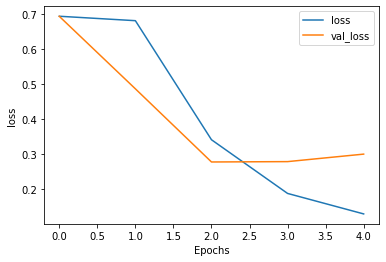

In [100]:
plot_graphs(history, 'loss')

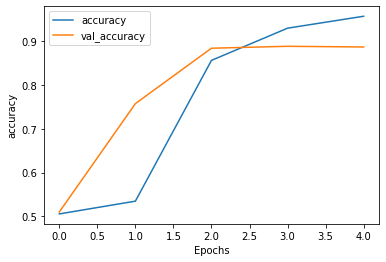

In [101]:
plot_graphs(history, 'accuracy')

#### 데이터 제출

In [102]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'


test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [103]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

앞서 데이터를 전처리하면서 저장한 테스트 입력 데이터를 불러온다.  
데이터를 불러오는 방법은 학습 데이터를 불러올 때와 동일.  
그리고 가장 좋은 검증 점수가 나온 모델을 model.load_weights로 불러오자.

In [104]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

InvalidArgumentError:  indices[111,30] = 82038 is not in [0, 74067)
	 [[node rnn_classifier_en/embedding_11/embedding_lookup (defined at <ipython-input-61-66a8bf0edd9e>:16) ]] [Op:__inference_predict_function_29948]

Errors may have originated from an input operation.
Input Source operations connected to node rnn_classifier_en/embedding_11/embedding_lookup:
 IteratorGetNext (defined at <ipython-input-104-b051c22c99e9>:1)

Function call stack:
predict_function


In [88]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)

InvalidArgumentError:  indices[111,30] = 82038 is not in [0, 74067)
	 [[node rnn_classifier_en/embedding_10/embedding_lookup (defined at <ipython-input-61-66a8bf0edd9e>:16) ]] [Op:__inference_predict_function_20465]

Errors may have originated from an input operation.
Input Source operations connected to node rnn_classifier_en/embedding_10/embedding_lookup:
 IteratorGetNext (defined at <ipython-input-81-234f038c52e6>:1)

Function call stack:
predict_function


### 컨볼루션 신경망 분류 모델
#### 모델 소개 
여러 계층의 합성곱(Convolution) 계층을 쌓은 모델인데, 입력받은 이미지에 대한 가장 좋으느 특징을 만들어 내도록 학습하고, 추출된 특징을 활용해 이미지를 분류하는 방식

RNN이 단어의 입력 순서를 중요하게 반영한다면, CNN은 문장의 지역 정보를 보존하면서 각 문장 성분의 등장 정보를 학습에 반영하는 구조.  

#### 모델 구현
기본적인 코드의 구조는 RNN에서 설명한 구조를 기반으로 하며, 모델 쪽 코드만 변경하면 손쉽게 CNN을 적용할 수 있음.  

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [5]:
model_name = 'cnn_classifier_en'

In [11]:
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_size' : 128,
        'num_filters' : 100,
        'dropout_rate' : 0.5,
        'hidden_dimension' : 250,
        'output_dimension' : 1}

In [15]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], # 임베딩 벡터를 생성
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], # Conv1D를 활용해 총 3개의 합성곱 레이어를 사용 & 각각 필터의 크기를 다르게 해서 값 추출
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D() # 맥스 풀링 레이어
        self.dropout = layers.Dropout(kargs['dropout_rate']) # Overfitting 방지하기 위한 Dropout
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'], # Fully-Connected 2개 층을 쌓아
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],# 최종 출력 차원인 kargs['output_dimension']과 출력을 맞춰 모델 구성 
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) 
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

\__init__을 통해 생성한 레이어들은 call함수를 통해 실행 가능.  
여기서 이전에 구성한 리스트 컴프리헨션 형태의 Conv1D 리스트 값을 각각 다른 필터의 값이 Conv1D를 통해 문장의 각기 다른 표현값들을 추출해서 concat을 통해 출력값들을 합침.  
이후 fc을 통해 분류 모델을 만들기 위한 학습 모델 구조를 완성.  

#### 모델 생성
model.compile을 통해 학습할 옵티마이저나 로스 함수 및 평가를 위한 평가지표 등을 설정.  

In [17]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

#### 모델 학습
RNN에서 구성했던 모델 저장 및 EarlyStopping 기능을 통해 학습 진행

In [18]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_en -- Folder create complete 



In [19]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/2
44/44 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.5949
Epoch 00001: val_accuracy improved from -inf to 0.77520, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 66s 1s/step - loss: 0.6709 - accuracy: 0.5949 - val_loss: 0.5595 - val_accuracy: 0.7752
Epoch 2/2
44/44 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8399
Epoch 00002: val_accuracy improved from 0.77520 to 0.87640, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 65s 1s/step - loss: 0.3789 - accuracy: 0.8399 - val_loss: 0.3093 - val_accuracy: 0.8764


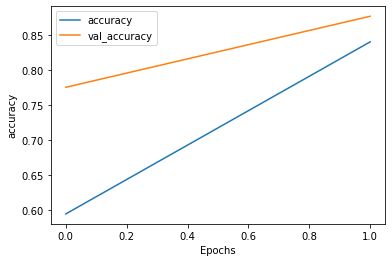

In [21]:
plot_graphs(history, 'accuracy')

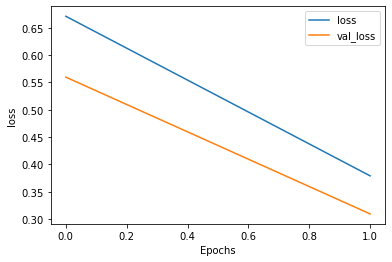

In [22]:
plot_graphs(history, 'loss')

#### 데이터 제출

In [23]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [24]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [25]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

InvalidArgumentError:  indices[100,29] = 82029 is not in [0, 74067)
	 [[node cnn_classifier_en/embedding_2/embedding_lookup (defined at <ipython-input-15-0851c50faad6>:23) ]] [Op:__inference_predict_function_2161]

Errors may have originated from an input operation.
Input Source operations connected to node cnn_classifier_en/embedding_2/embedding_lookup:
 IteratorGetNext (defined at <ipython-input-25-b051c22c99e9>:1)

Function call stack:
predict_function


In [26]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment": list(predictions)} )
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)

NameError: name 'predictions' is not defined